##### Importy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.src.layers import BatchNormalization, Dropout
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import warnings
import keras_tuner as kt
import itertools
import time
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf

warnings.filterwarnings('ignore')

##### 1. Wczytanie danych

In [2]:
# df_final = pd.read_csv("all_data.csv", parse_dates=['timestamp'])

In [3]:
# 1. Wybór losowego budynku
# random_building = np.random.choice(df_final['building_id'].unique())

def visualize(building_data, type=None):

    # 2. Filtrowanie danych dla wybranego budynku i roku 2017
    if type == "small":
        building_data = building_data[(building_data['timestamp'].dt.year == 2017)&(building_data['timestamp'].dt.month == 3)].sort_values('timestamp')

    # 3. Tworzenie wykresu scatter
    plt.figure(figsize=(15, 6))
    plt.plot(building_data['timestamp'], building_data['energy_consumption'], alpha=0.7)

    # 4. Formatowanie wykresu
    plt.title(f'Zużycie energii w czasie dla budynku {building_data["building_id"]} (2017)\n'
              f'Średnia temperatura: {building_data["airTemperature"].mean():.1f}°C', fontsize=14)
    plt.xlabel('Czas', fontsize=12)
    plt.ylabel('Zużycie energii', fontsize=12)


    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [4]:
# 1. Wczytanie i przygotowanie danych
def load_and_preprocess(file_path = None, data = None):
    if data is None:
        data = pd.read_csv(file_path, parse_dates=['timestamp'])
    data = data.sort_values('timestamp').set_index('timestamp')
    data = data.asfreq('H')

    for col in data.columns:
        data[col] = data[col].replace([np.inf, -np.inf], np.nan)
        data[col] = data[col].interpolate(method='time', limit_direction='both')
        data[col] = data[col].ffill().bfill()

    return data[['energy_consumption', 'airTemperature']]

##### 2. Podział danych

In [5]:
# train_size = int(len(y) * 0.8)
# train, test = y.iloc[:train_size], y.iloc[train_size:]

##### ARIMA

In [6]:
def find_arima_params(train, seasonal=False, m=1):
    """
    Zaawansowane znajdowanie parametrów ARIMA z wykorzystaniem:
    - Testów stacjonarności do określenia d
    - Analizy ACF/PACF do wstępnego określenia zakresów p i q
    - Przeszukiwania siatki parametrów z walidacją kroczącą
    - Minimalizacji kryterium AIC
    """
    warnings.filterwarnings("ignore")

    # 1. Określenie parametru d
    d = determine_differencing_order(train)
    stationary_series = train.diff(d).dropna() if d > 0 else train.copy()

    # 2. Analiza ACF/PACF dla wstępnego określenia zakresów p i q
    max_lags = 20
    acf_vals = acf(stationary_series, nlags=max_lags, fft=True)
    pacf_vals = pacf(stationary_series, nlags=max_lags)

    # Sugerowane zakresy na podstawie ACF/PACF
    p_range = suggest_p_from_pacf(pacf_vals)
    q_range = suggest_q_from_acf(acf_vals)

    # 3. Przeszukiwanie siatki parametrów
    best_aic = np.inf
    best_order = (1, d, 1)  # Domyślne wartości

    # Generuj wszystkie kombinacje p i q
    pdq = itertools.product(p_range, [d], q_range)

    for order in pdq:
        try:
            model = ARIMA(train, order=order).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = order
        except:
            continue

    # 4. Walidacja znalezionych parametrów
    validated_order = validate_arima_order(train, best_order)

    warnings.resetwarnings()
    return validated_order


def determine_differencing_order(series, max_diff=2):
    """
    Określa rząd różnicowania (d) na podstawie testów stacjonarności
    """
    for d in range(max_diff + 1):
        if d > 0:
            diff_series = series.diff(d).dropna()
        else:
            diff_series = series.copy()

        # Test ADF
        adf_result = adfuller(diff_series)
        # Test KPSS
        try:
            kpss_result = kpss(diff_series, regression='c')
        except:
            kpss_result = (None, 1.0)  # W przypadku błędu przyjmujemy niestacjonarność

        # Warunki stacjonarności
        if adf_result[1] <= 0.05 and kpss_result[1] > 0.05:
            return d

    return max_diff  # Zwróć maksymalny testowany rząd


def suggest_p_from_pacf(pacf_vals, threshold=0.2):
    """
    Sugeruje zakres p na podstawie PACF
    """
    significant_lags = np.where(np.abs(pacf_vals) > threshold)[0]
    if len(significant_lags) > 0:
        max_p = min(np.max(significant_lags) + 2, 5)  # Ogranicz do 5
        return range(0, max_p + 1)
    return [0, 1, 2]


def suggest_q_from_acf(acf_vals, threshold=0.2):
    """
    Sugeruje zakres q na podstawie ACF
    """
    significant_lags = np.where(np.abs(acf_vals) > threshold)[0]
    if len(significant_lags) > 0:
        max_q = min(np.max(significant_lags) + 2, 5)  # Ogranicz do 5
        return range(0, max_q + 1)
    return [0, 1, 2]


def validate_arima_order(series, order, n_folds=3):
    """
    Walidacja parametrów z użyciem kroczącej walidacji
    """
    p, d, q = order
    train_size = len(series)
    fold_size = train_size // (n_folds + 1)

    aic_scores = []

    for i in range(1, n_folds + 1):
        train = series.iloc[:i * fold_size]
        try:
            model = ARIMA(train, order=order).fit()
            aic_scores.append(model.aic)
        except:
            aic_scores.append(np.inf)

    # Sprawdź czy prostsze modele nie dają podobnych wyników
    simpler_models = [
        (max(p - 1, 0), d, q),
        (p, d, max(q - 1, 0)),
        (max(p - 1, 0), d, max(q - 1, 0))
    ]

    for test_order in simpler_models:
        try:
            model = ARIMA(series, order=test_order).fit()
            if model.aic < np.mean(aic_scores):
                return test_order
        except:
            continue

    return order


##### SARIMA

In [7]:
def find_optimal_seasonal_params(train, s=24, non_seasonal_order=(1, 1, 1)):
    """
    Znajduje optymalne parametry sezonowe (P,D,Q) dla SARIMA
    z ustaloną sezonowością s=24.

    Parametry:
    - train: szereg czasowy treningowy
    - s: okres sezonowości (domyślnie 24 dla danych godzinnych)
    - non_seasonal_order: uprzednio określone parametry (p,d,q)

    Zwraca:
    - najlepsze seasonal_order (P,D,Q,s)
    """
    warnings.filterwarnings("ignore")

    # 1. Określenie sezonowego rzędu różnicowania (D)
    D = determine_seasonal_differencing_order(train, s)

    # 2. Ograniczone zakresy parametrów do przetestowania
    P_range = [0, 1, 2]  # Sezonowe autoregresja
    Q_range = [0, 1, 2]  # Sezonowa średnia ruchoma

    # 3. Przeszukiwanie siatki parametrów
    best_aic = np.inf
    best_order = (1, D, 1, s)  # Domyślne wartości

    for P, Q in itertools.product(P_range, Q_range):
        seasonal_order = (P, D, Q, s)
        try:
            model = SARIMAX(train,
                            order=non_seasonal_order,
                            seasonal_order=seasonal_order).fit(disp=False)

            if model.aic < best_aic:
                best_aic = model.aic
                best_order = seasonal_order
        except:
            continue

    # 4. Walidacja prostszych modeli
    validated_order = validate_seasonal_order(train, non_seasonal_order, best_order)

    warnings.resetwarnings()
    return validated_order


def determine_seasonal_differencing_order(series, s, max_D=1):
    """
    Określa sezonowy rząd różnicowania (D) na podstawie:
    - Testu Canova-Hansona dla sezonowości
    - Wizualnej inspecji sezonowych ACF
    """
    # Test Canova-Hansona (dostępny w statsmodels 0.14+)
    try:
        from statsmodels.tsa.statespace.tools import seasonal_decompose
        decomposition = seasonal_decompose(series, period=s)
        resid = decomposition.resid.dropna()
        if abs(resid).mean() < 0.1 * abs(series).mean():
            return 0
    except:
        pass

    # Różnicowanie sezonowe i test ACF
    for D in range(max_D + 1):
        if D > 0:
            diff_series = series.diff(s).dropna()
        else:
            diff_series = series.copy()

        # Sprawdź czy sezonowość została usunięta
        acf_vals = acf(diff_series, nlags=s + 3, fft=True)
        if all(abs(acf_vals[s - 1:s + 2]) < 0.2):  # Sprawdź opóźnienie sezonowe
            return D

    return max_D


def validate_seasonal_order(series, non_seasonal_order, seasonal_order, n_folds=3):
    """
    Waliduje znalezione parametry sezonowe z użyciem kroczącej walidacji
    """
    P, D, Q, s = seasonal_order
    train_size = len(series)
    fold_size = train_size // (n_folds + 1)

    aic_scores = []

    for i in range(1, n_folds + 1):
        train = series.iloc[:i * fold_size]
        try:
            model = SARIMAX(train,
                            order=non_seasonal_order,
                            seasonal_order=seasonal_order).fit(disp=False)
            aic_scores.append(model.aic)
        except:
            aic_scores.append(np.inf)

    # Sprawdź czy prostsze modele nie dają podobnych wyników
    simpler_models = [
        (max(P - 1, 0), D, Q, s),
        (P, D, max(Q - 1, 0), s),
        (max(P - 1, 0), D, max(Q - 1, 0), s)
    ]

    current_mean_aic = np.mean(aic_scores)
    best_order = seasonal_order

    for test_order in simpler_models:
        try:
            model = SARIMAX(series,
                            order=non_seasonal_order,
                            seasonal_order=test_order).fit(disp=False)
            if model.aic < current_mean_aic:
                best_order = test_order
                current_mean_aic = model.aic
        except:
            continue

    return best_order


##### ARIMAX/SARIMAX

In [8]:

def doArimaModels(data, trainData, train_size):

    arimaTimes = dict()

    start = time.time()
    arima_order = find_arima_params(trainData)
    end = time.time()
    arimaTimes["arimaSearch"] = end - start

    start = time.time()
    arima_model = ARIMA(trainData, order=arima_order).fit()
    end = time.time()
    arimaTimes["arimaModel"] = end - start

    start = time.time()
    seasonal_order = find_optimal_seasonal_params(trainData, s=24, non_seasonal_order=arima_order)
    end = time.time()
    arimaTimes["arimaSeasonalSearch"] = end - start

    start = time.time()
    sarima_model = SARIMAX(trainData, order=arima_order, seasonal_order=seasonal_order).fit()
    end = time.time()
    arimaTimes["sarimaModel"] = end - start

    if 'airTemperature' in data.columns:
        exog = data['airTemperature']
        train_exog, test_exog = exog.iloc[:train_size], exog.iloc[train_size:]

        start = time.time()
        arimax_model = ARIMA(trainData, exog=train_exog, order=arima_order).fit()
        end = time.time()
        arimaTimes["arimaxModel"] = end - start

        start = time.time()
        sarimax_model = SARIMAX(trainData, exog=train_exog, order=arima_order,
                                seasonal_order=seasonal_order).fit()
        end = time.time()
        arimaTimes["sarimaxModel"] = end - start
    else:
        arimax_model = None
        sarimax_model = None

    return arima_model, sarima_model, arimax_model, sarimax_model, test_exog, arimaTimes

# doArimaModels(data, train, train_size)

##### LSTM

In [9]:
n_steps = 24

def prepare_lstm_data(data, n_steps=24):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data.values.reshape(-1, 1))
    X, y = [], []
    for i in range(n_steps, len(scaled)):
        X.append(scaled[i - n_steps:i, 0])
        y.append(scaled[i, 0])
    return np.array(X), np.array(y), scaler

def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=256, step=32),
        input_shape=(n_steps, 1)
    ))
    model.add(Dense(1))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), loss='mse')
    return model

def doLSTM(trainData, testData):
    print("Trenowanie LSTM...")

    lstmTimes = dict()

    start = time.time()
    X_train_lstm, y_train_lstm, lstm_scaler = prepare_lstm_data(trainData, n_steps)
    X_test_lstm, y_test_lstm, _ = prepare_lstm_data(pd.concat([trainData[-24:], testData]), n_steps)
    end = time.time()
    lstmTimes["LstmTrain"] = end - start

    start = time.time()
    tuner = kt.RandomSearch(build_model, objective='val_loss', max_trials=10)
    tuner.search(X_train_lstm, y_train_lstm, epochs=20, validation_split=0.2)
    lstm_model = tuner.get_best_models()[0]
    end = time.time()

    lstmTimes["LstmTuner"] = end - start

    start = time.time()
    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, verbose=0)
    end = time.time()

    lstmTimes["LSTM"] = end - start

    return lstm_model, X_test_lstm, y_test_lstm, lstm_scaler, lstmTimes


    # lstm_model = doLSTM(train)


##### Random Forest


In [10]:
def create_rolling_features(data, window=24):
    df = pd.DataFrame(data)
    for i in range(1, window + 1):
        df[f'lag_{i}'] = df['energy_consumption'].shift(i)

    print(df)
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    return df.dropna()

def doRandomForest(trainData, testData):

    rfTimes = dict()

    print("Trenowanie Random Forest...")
    start = time.time()
    train_rf = create_rolling_features(trainData)
    X_train_rf, y_train_rf = train_rf.drop('energy_consumption', axis=1), train_rf['energy_consumption']
    end = time.time()

    rfTimes["RFTrain"] = end - start

    start = time.time()
    test_rf = create_rolling_features(pd.concat([trainData[-24:], testData]))
    X_test_rf, y_test_rf = test_rf.drop('energy_consumption', axis=1), test_rf['energy_consumption']
    end = time.time()

    rfTimes["RFTest"] = end - start

    start = time.time()
    rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
    rf_model.fit(X_train_rf, y_train_rf)
    end = time.time()

    rfTimes["RFModel"] = end - start

    return rf_model, X_test_rf, y_test_rf, rfTimes

# doRandomForest(train)


In [11]:
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}


##### Porównanie

In [12]:
# df_final = pd.read_csv("all_data.csv", parse_dates=['timestamp'])

In [13]:
df_final.groupby("building_id").head()

,timestamp,building_id,energy_consumption,site_id,sqm,lat,lng,timezone,industry,yearbuilt,numberoffloors,occupants,airTemperature
0,2016-01-01 00:00:00,Bear_assembly_Angel,237.8500,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN,4.4
1,2016-01-01 01:00:00,Bear_assembly_Angel,221.2500,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN,4.4
2,2016-01-01 02:00:00,Bear_assembly_Angel,222.5000,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN,4.4
3,2016-01-01 03:00:00,Bear_assembly_Angel,221.4000,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN,4.4
4,2016-01-01 04:00:00,Bear_assembly_Angel,224.2500,Bear,22117.0,37.871903,-122.260729,US/Pacific,NaN,1933.0,6.0,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25195042,2016-01-01 00:00:00,Wolf_science_Alfreda,87.6400,Wolf,914.0,53.349800,6.260300,Europe/Dublin,Education,NaN,NaN,NaN,1.9
25195043,2016-01-01 01:00:00,Wolf_science_Alfreda,87.1525,Wolf,914.0,53.349800,6.260300,Europe/Dublin,Education,NaN,NaN,NaN,1.6
25195044,2016-01-01 02:00:00,Wolf_science_Alfreda,86.9800,Wolf,914.0,53.349800,6.260300,Europe/Dublin,Education,NaN,NaN,NaN,0.7
25195045,2016-01-01 03:00:00,Wolf_science_Alfreda,87.1375,Wolf,914.0,53.349800,6.260300,Europe/Dublin,Education,NaN,NaN,NaN,0.8


In [14]:
# # Posortuj unikalne building_id
# sorted_buildings = sorted(df_final['building_id'].unique())
#
# # Wybierz pierwsze 5 kolejnych
# selected_buildings = sorted_buildings[:1]
#
# for i in selected_buildings:
#     data = df_final[df_final['building_id'] == i]
#     data = data[(data['timestamp'].dt.year == 2017)&(data['timestamp'].dt.month == 3)].sort_values('timestamp')
#     visualize(data)
#     y = data['energy_consumption']
#     train_size = int(len(y) * 0.8)
#     train, test = y.iloc[:train_size], y.iloc[train_size:]
#     arima_model, sarima_model, arimax_model, sarimax_model, test_exog, arimaTimes = doArimaModels(data, train, train_size)
#     print("ARIMA DONE")
#     lstm_model, X_test_lstm, y_test_lstm, lstm_scaler, lstmTimes = doLSTM(train)
#     print("LSTM DONE")
#     rf_model, X_test_rf, y_test_rf, rfTimes = doRandomForest(train)
#     print("RF DONE")
#     results = pd.DataFrame(index=test.index)
# metrics = []
#
# # ARIMA
# results['ARIMA'] = arima_model.forecast(len(test))
# metrics.append(evaluate_model(test, results['ARIMA'], 'ARIMA'))
#
# # # SARIMA
# results['SARIMA'] = sarima_model.forecast(len(test))
# metrics.append(evaluate_model(test, results['SARIMA'], 'SARIMA'))
#
# # ARIMAX/SARIMAX
# if 'airTemperature' in data.columns:
#     results['ARIMAX'] = arimax_model.forecast(len(test), exog=test_exog)
#     metrics.append(evaluate_model(test, results['ARIMAX'], 'ARIMAX'))
#
#     results['SARIMAX'] = sarimax_model.forecast(len(test), exog=test_exog)
#     metrics.append(evaluate_model(test, results['SARIMAX'], 'SARIMAX'))
#
#     # Random Forest
#     results['Random_Forest'] = rf_model.predict(X_test_rf)
#     metrics.append(evaluate_model(test, results['Random_Forest'], 'Random Forest'))
#
#     # LSTM
#     lstm_pred = lstm_model.predict(X_test_lstm)
#     results['LSTM'] = lstm_scaler.inverse_transform(lstm_pred).flatten()
#     metrics.append(evaluate_model(test, results['LSTM'], 'LSTM'))
#
#     fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
#     axes = axes.flatten()  # Spłaszczenie do 1D listy osi
#
#     for i, col in enumerate(results.columns[:6]):
#         ax = axes[i]
#         ax.plot(train, label='Train')
#         ax.plot(test, label='Test', alpha=0.7)
#         ax.plot(results[col], label=col, alpha=0.7)
#         ax.set_title(f'Wykres: {col}')
#         ax.legend()
#
#     plt.tight_layout()
#     plt.show()
#
#     # 10. Podsumowanie metryk
#     metrics_df = pd.DataFrame(metrics).set_index('Model')
#     print("\nMetryki efektywności:")
#     print(metrics_df.sort_values('RMSE'))


In [15]:
# # Posortuj unikalne building_id
# sorted_buildings = sorted(df_final['building_id'].unique())
#
# # Wybierz pierwsze 5 kolejnych
# selected_buildings = sorted_buildings[:1]
#
# for i in selected_buildings:
#     data = df_final[df_final['building_id'] == i]
#     data = data[(data['timestamp'].dt.year == 2017)&(data['timestamp'].dt.month == 3)].sort_values('timestamp')
#
#     visualize(data)
#     data = load_and_preprocess(data = data)
#
#     y = data['energy_consumption']
#     train_size = int(len(y) * 0.8)
#     train, test = y.iloc[:train_size], y.iloc[train_size:]
#
#     lstm_model, X_test_lstm, y_test_lstm, lstm_scaler, lstmTimes = doLSTM(train, test)
#     print("LSTM DONE")
#     rf_model, X_test_rf, y_test_rf, rfTimes = doRandomForest(train, test)
#     print("RF DONE")
#     results = pd.DataFrame(index=test.index)
#
# metrics = []
#
# # Random Forest
# results['Random_Forest'] = rf_model.predict(X_test_rf)
# metrics.append(evaluate_model(test, results['Random_Forest'], 'Random Forest'))
#
# # LSTM
# lstm_pred = lstm_model.predict(X_test_lstm)
# results['LSTM'] = lstm_scaler.inverse_transform(lstm_pred).flatten()
# metrics.append(evaluate_model(test, results['LSTM'], 'LSTM'))
#
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))
# axes = axes.flatten()  # Spłaszczenie do 1D listy osi
#
# for i, col in enumerate(results.columns[:6]):
#     ax = axes[i]
#     ax.plot(train, label='Train')
#     ax.plot(test, label='Test', alpha=0.7)
#     ax.plot(results[col], label=col, alpha=0.7)
#     ax.set_title(f'Wykres: {col}')
#     ax.legend()
#
# plt.tight_layout()
# plt.show()
#
# # 10. Podsumowanie metryk
# metrics_df = pd.DataFrame(metrics).set_index('Model')
# print("\nMetryki efektywności:")
# print(metrics_df.sort_values('RMSE'))


In [16]:
# # Posortuj unikalne building_id
# sorted_buildings = sorted(df_final['building_id'].unique())
#
# # Wybierz pierwsze 5 kolejnych
# selected_buildings = sorted_buildings[:1]
#
# for i in selected_buildings:
#     data = df_final[df_final['building_id'] == i]
#     # data = data[(data['timestamp'].dt.year == 2017)&(data['timestamp'].dt.month == 3)].sort_values('timestamp')
#
#     visualize(data)
#     data = load_and_preprocess(data = data)
#
#     y = data['energy_consumption']
#     train_size = int(len(y) * 0.8)
#     train, test = y.iloc[:train_size], y.iloc[train_size:]
#
#     lstm_model, X_test_lstm, y_test_lstm, lstm_scaler, lstmTimes = doLSTM(train, test)
#     print("LSTM DONE")
#     rf_model, X_test_rf, y_test_rf, rfTimes = doRandomForest(train, test)
#     print("RF DONE")
#     results = pd.DataFrame(index=test.index)
#
# metrics = []
#
# # Random Forest
# results['Random_Forest'] = rf_model.predict(X_test_rf)
# metrics.append(evaluate_model(test, results['Random_Forest'], 'Random Forest'))
#
# # LSTM
# lstm_pred = lstm_model.predict(X_test_lstm)
# results['LSTM'] = lstm_scaler.inverse_transform(lstm_pred).flatten()
# metrics.append(evaluate_model(test, results['LSTM'], 'LSTM'))
#
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))
# axes = axes.flatten()  # Spłaszczenie do 1D listy osi
#
# for i, col in enumerate(results.columns[:6]):
#     ax = axes[i]
#     ax.plot(train, label='Train')
#     ax.plot(test, label='Test', alpha=0.7)
#     ax.plot(results[col], label=col, alpha=0.7)
#     ax.set_title(f'Wykres: {col}')
#     ax.legend()
#
# plt.tight_layout()
# plt.show()
#
# # 10. Podsumowanie metryk
# metrics_df = pd.DataFrame(metrics).set_index('Model')
# print("\nMetryki efektywności:")
# print(metrics_df.sort_values('RMSE'))


In [20]:

def prepare_lstm_data(data, n_steps=24):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(n_steps, len(scaled)):
        X.append(scaled[i - n_steps:i, :])
        y.append(scaled[i, 0])  # Zakładając, że energy_consumption jest pierwszą kolumną
    return np.array(X), np.array(y), scaler



def doLSTM(trainData, testData, n_steps=24):
    print("Trenowanie LSTM...")
    lstmTimes = {}

    # Przygotowanie danych - używamy energy_consumption i airTemperature
    data_for_training = trainData[['energy_consumption', 'airTemperature']].values
    data_for_testing = pd.concat([trainData[-n_steps:], testData])[['energy_consumption', 'airTemperature']].values

    start = time.time()
    X_train_lstm, y_train_lstm, lstm_scaler = prepare_lstm_data(data_for_training, n_steps)
    X_test_lstm, y_test_lstm, _ = prepare_lstm_data(data_for_testing, n_steps)

    def build_model(hp):
        model = Sequential()
        model.add(LSTM(
            units=hp.Int('units', min_value=32, max_value=256, step=32),
            input_shape=(n_steps, X_train_lstm.shape[2]),
            return_sequences=False
        ))
        model.add(Dense(1))
        model.compile(
            optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
            loss='mse',
            metrics=['mae']
        )
        return model

    end = time.time()
    lstmTimes["LstmTrain"] = end - start

    # Strojenie hiperparametrów
    start = time.time()
    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=10,
        executions_per_trial=1,
        directory='lstm_tuning',
        project_name='energy_consumption'
    )
    tuner.search(
        X_train_lstm,
        y_train_lstm,
        epochs=20,
        validation_split=0.2,
        batch_size=32,
        verbose=1
    )
    lstm_model = tuner.get_best_models(num_models=1)[0]
    end = time.time()
    lstmTimes["LstmTuner"] = end - start

    # Trenowanie finalnego modelu
    start = time.time()
    history = lstm_model.fit(
        X_train_lstm,
        y_train_lstm,
        epochs=50,  # Więcej epok dla lepszego dopasowania
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )
    end = time.time()
    lstmTimes["LSTM"] = end - start

    return lstm_model, X_test_lstm, y_test_lstm, lstm_scaler, lstmTimes, history

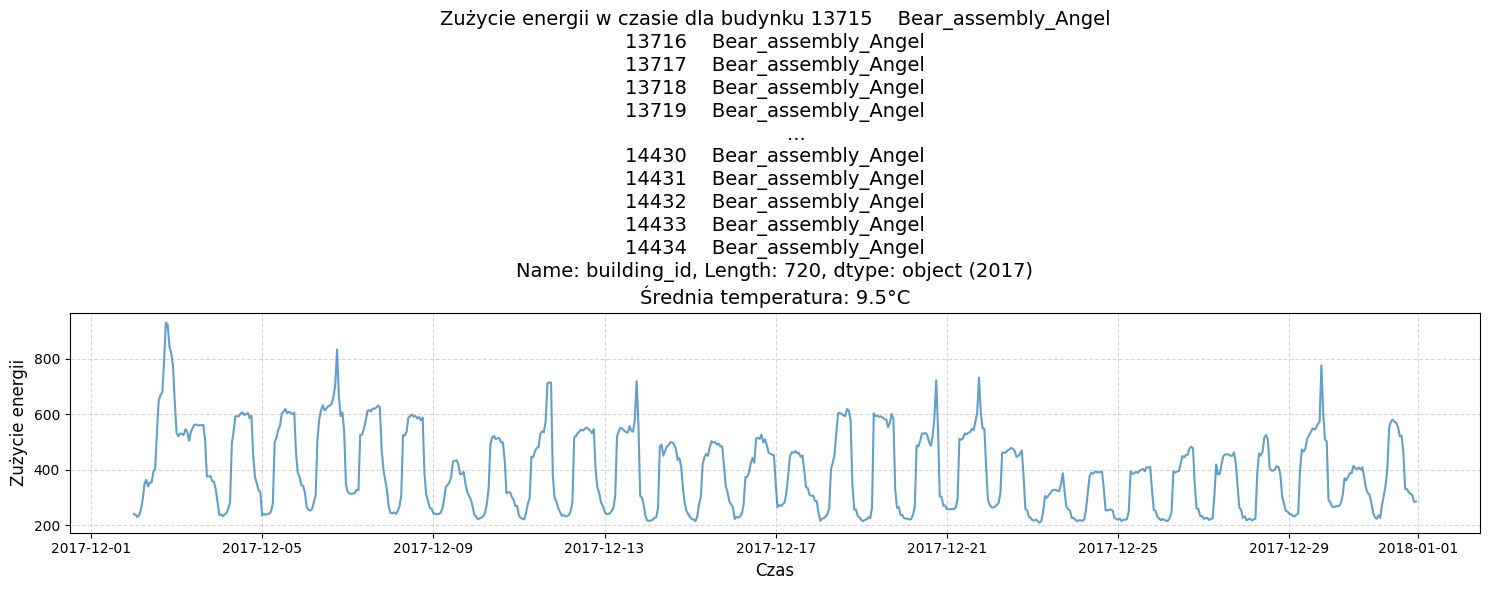

Trenowanie LSTM...


KeyError: "None of [Index(['energy_consumption', 'airTemperature'], dtype='object', name='timestamp')] are in the [index]"

In [21]:
# Posortuj unikalne building_id
sorted_buildings = sorted(df_final['building_id'].unique())

# Wybierz pierwsze 5 kolejnych
selected_buildings = sorted_buildings[:1]

for i in selected_buildings:
    data = df_final[df_final['building_id'] == i].dropna(subset=['energy_consumption'])
    data_lstm = data.copy()

    data_lstm = load_and_preprocess(data = data_lstm)

    # data = data[(data['timestamp'].dt.year == 2017)&(data['timestamp'].dt.month == 3)].sort_values('timestamp')
    data = data[-720:] # tylko ostatnie 2160 elementów (3 miesiące)

    visualize(data)
    data = load_and_preprocess(data = data)

    y = data['energy_consumption']
    train_size = int(len(y) * 0.8)
    train, test = y.iloc[:train_size], y.iloc[train_size:]

    train_lstm, test_lstm = data_lstm.iloc[:(len(data_lstm)-(len(y)-train_size))], y.iloc[train_size:]

    lstm_model, X_test_lstm, y_test_lstm, lstm_scaler, lstmTimes = doLSTM(train, test, 24)
    print("LSTM DONE")
    rf_model, X_test_rf, y_test_rf, rfTimes = doRandomForest(train, test)
    print("RF DONE")
    results = pd.DataFrame(index=test.index)

metrics = []

# Random Forest
results['Random_Forest'] = rf_model.predict(X_test_rf)
metrics.append(evaluate_model(test, results['Random_Forest'], 'Random Forest'))

# LSTM
lstm_pred = lstm_model.predict(X_test_lstm)
results['LSTM'] = lstm_scaler.inverse_transform(lstm_pred).flatten()
metrics.append(evaluate_model(test, results['LSTM'], 'LSTM'))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))
axes = axes.flatten()  # Spłaszczenie do 1D listy osi

for i, col in enumerate(results.columns[:6]):
    ax = axes[i]
    ax.plot(train, label='Train')
    ax.plot(test, label='Test', alpha=0.7)
    ax.plot(results[col], label=col, alpha=0.7)
    ax.set_title(f'Wykres: {col}')
    ax.legend()

plt.tight_layout()
plt.show()

# 10. Podsumowanie metryk
metrics_df = pd.DataFrame(metrics).set_index('Model')
print("\nMetryki efektywności:")
print(metrics_df.sort_values('RMSE'))
